In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker 
import pycountry_convert as pc
#import folium
from datetime import datetime,date
from scipy.interpolate import make_interp_spline, BSpline
from lmfit import Minimizer, Parameters, report_fit
import chart_studio.plotly as py

%matplotlib inline

import os

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import cufflinks as cf

In [2]:
def Cauchy_cumulative_hazard(x,loc,scale,decaybase):
    decayterm=np.power(decaybase,(x-loc))
    decayterm[np.where((x-loc)<0)]=1.0
    z=(x-loc)/(scale*decayterm)
    return -np.log(0.5 - np.arctan(z)/np.pi)

# define objective function: returns the array to be minimized
def Cauchy_cumulative_hazard_residual(params, x, data):
    """Model a decaying sine wave and subtract data."""
    amp = params['amp']
    loc = params['loc']
    scale = params['scale']
    decaybase=params['decaybase']
    decayterm=np.power(decaybase,(x-loc))
    decayterm[np.where((x-loc)<0)]=1.0
    z=(x-loc)/(scale*decayterm)
    model = amp * (-np.log(0.5 - np.arctan(z)/np.pi))
    return model - data

In [3]:
fn='data/COVID19/CanadaOntarioTorontCOVID-19ConfirmedCases.csv'
CanadaOntarioToronto=pd.read_csv(fn)
CanadaOntarioToronto.columns

Index(['Date_health_region', 'Toronto', 'Ottawa', 'Ontario', 'CA'], dtype='object')

In [4]:
CanadaOntarioToronto['date']=pd.to_datetime(CanadaOntarioToronto['Date_health_region'])
CanadaOntarioToronto=CanadaOntarioToronto.drop('Ottawa',axis=1)
CanadaOntarioToronto=CanadaOntarioToronto.drop('Date_health_region',axis=1)
CanadaOntarioToronto=CanadaOntarioToronto[CanadaOntarioToronto['CA']>60]

In [5]:
CanadaOntarioToronto.head()

,Toronto,Ontario,CA,date
4,18,32,67,2020-03-08
5,20,35,86,2020-03-09
6,21,37,95,2020-03-10
7,23,42,116,2020-03-11
8,31,59,156,2020-03-12


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 376
    # data points      = 61
    # variables        = 4
    chi-square         = 0.01740652
    reduced chi-square = 3.0538e-04
    Akaike info crit   = -489.868847
    Bayesian info crit = -481.425352
[[Variables]]
    amp:        0.11355647 +/- 0.01768299 (15.57%) (init = 1)
    scale:      8.73930043 +/- 1.41973849 (16.25%) (init = 1)
    loc:        23.2598629 +/- 0.95333045 (4.10%) (init = 70)
    decaybase:  0.85000000 +/- 0.03563304 (4.19%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   = -0.997
    C(loc, decaybase)   = -0.926
    C(amp, loc)         =  0.919
    C(scale, loc)       = -0.877
    C(scale, decaybase) =  0.728
    C(amp, scale)       = -0.691


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



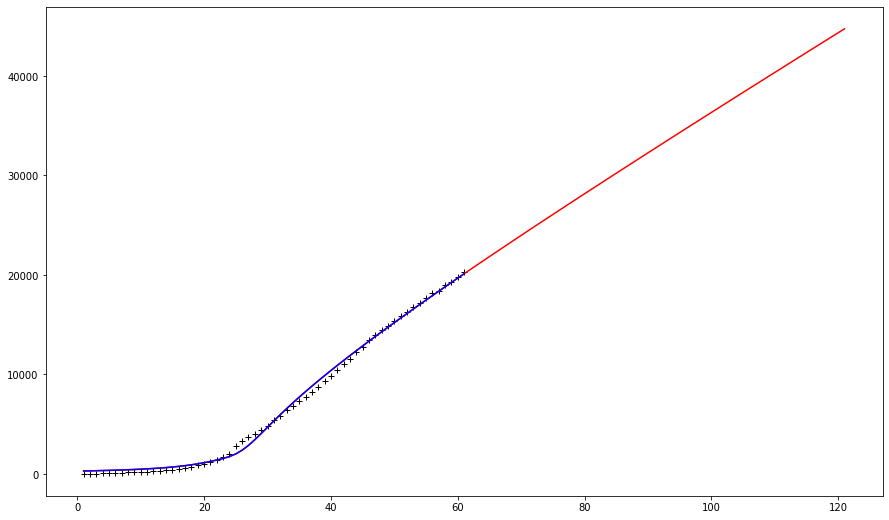

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [6]:
# basic data
theCountry='Ontario'
threshhold=3
theData=CanadaOntarioToronto[CanadaOntarioToronto[theCountry]>threshhold] 
theData=theData.set_index('date')
data=theData[theCountry]
start_date= data.index[0]
end_date= data.index[-1]                           
dateData=pd.date_range(start=start_date,end=end_date)
forecastDays=60

dateForecast= pd.date_range(start=end_date,periods=forecastDays+1)[1:] 
dateObsForecast=dateData.append(dateForecast)
#dateObsForecast

                         
# define objective function: returns the array to be minimized
  # normalize case data
last=data[-1]
data=data/last
  # set x values interval = 1day
dataLen=data.count()
x = np.linspace(1, dataLen, dataLen)

# create a set of Parameters
params = Parameters()
params.add('amp', value=1)
params.add('scale', value=1, min=0.1)
params.add('loc', value=70, min=0)
params.add('decaybase',value=1, min=0.85,max=1.005)  # shparly increase value>1

# do fit, here with the default leastsq algorithm
minner = Minimizer(Cauchy_cumulative_hazard_residual, params, fcn_args=(x, data))
result = minner.minimize()

# calculate final result
forecastdays=forecastDays
final = data + result.residual
x1=np.linspace(1,dataLen+forecastdays,dataLen+forecastdays)
scale=result.params['scale'].value
amp=result.params['amp'].value
loc=result.params['loc'].value
decaybase=result.params['decaybase'].value

y1=amp*Cauchy_cumulative_hazard(x1,loc,scale,decaybase)  # forecast
nn=np.int(np.ceil(loc))
y1[:nn]=final.iloc[:nn] # replace data before

# write error report
report_fit(result)
fig0=plt.figure(figsize=(15,9))
plt.plot(x, data*last, 'k+')
plt.plot(x1,y1*last,'r-')
plt.plot(x, final*last, 'b-')
fig0.show()

output = pd.DataFrame({'date' : [],'Forecast':[],'Cases': [],'Fitting':[],'Increase':[]})
output

output['date']=dateObsForecast
output['Forecast']=y1*last
output['Cases'].iloc[:dataLen]=data.values*last
output['Fitting'].iloc[:dataLen]=final.values*last
output['Increase'].iloc[1:]=(y1[1:]-y1[:-1])*last
output=output.set_index('date')

output.iplot(asFigure=True,
             mode='lines+markers',
             size=6,secondary_y = 'Increase',
             secondary_y_title='Increase',
             xTitle='Date',
             yTitle='Cases',
             title='Projected COVID-19 Cases in Ontario')

@interact
def plot_ProjectedOntarioCOVID19():
    fig=output.iplot(asFigure=True,
                 mode='lines+markers',
                 size=6,secondary_y = 'Increase',
                 secondary_y_title='Increase',
                 xTitle='Date',
                 yTitle='Cases',
                 title='Projected COVID-19 Cases in Ontario',
                 theme='solar',
                 filename='COVID19-Ontario',
                 sharing='public')
    fig.show()
    url=py.iplot(fig, filename='COVID19-Ontario')
    print(url)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 279
    # data points      = 61
    # variables        = 4
    chi-square         = 0.02404955
    reduced chi-square = 4.2192e-04
    Akaike info crit   = -470.149279
    Bayesian info crit = -461.705783
[[Variables]]
    amp:        0.18501840 +/- 0.04234279 (22.89%) (init = 1)
    scale:      10.0205809 +/- 1.72166556 (17.18%) (init = 1)
    loc:        28.0321519 +/- 1.91184778 (6.82%) (init = 70)
    decaybase:  0.91733549 +/- 0.03204052 (3.49%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, decaybase)   =  0.997
    C(amp, loc)         =  0.985
    C(loc, decaybase)   =  0.984
    C(scale, loc)       = -0.934
    C(scale, decaybase) = -0.912
    C(amp, scale)       = -0.888


/media/Data1/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



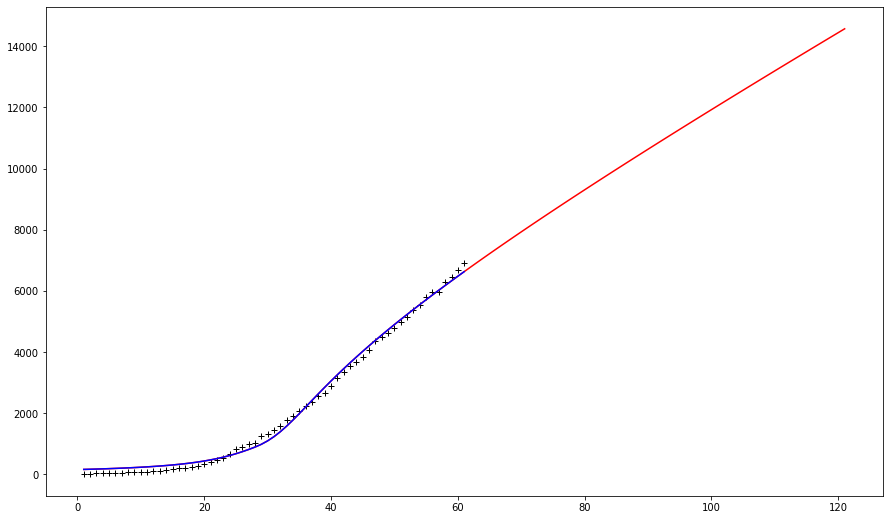

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [7]:
# basic data
theCountry='Toronto'
figfiletitle='Projected COVID-19 Cases in ' + theCountry
figfilename= 'COVID19-' + theCountry
threshhold=3
theData=CanadaOntarioToronto[CanadaOntarioToronto[theCountry]>threshhold] 
theData=theData.set_index('date')
data=theData[theCountry]
start_date= data.index[0]
end_date= data.index[-1]                           
dateData=pd.date_range(start=start_date,end=end_date)
forecastDays=60

dateForecast= pd.date_range(start=end_date,periods=forecastDays+1)[1:] 
dateObsForecast=dateData.append(dateForecast)
#dateObsForecast

                         
# define objective function: returns the array to be minimized
  # normalize case data
last=data[-1]
data=data/last
  # set x values interval = 1day
dataLen=data.count()
x = np.linspace(1, dataLen, dataLen)

# create a set of Parameters
params = Parameters()
params.add('amp', value=1)
params.add('scale', value=1, min=0.1)
params.add('loc', value=70, min=0)
params.add('decaybase',value=1, min=0.85,max=1.005)  # shparly increase value>1

# do fit, here with the default leastsq algorithm
minner = Minimizer(Cauchy_cumulative_hazard_residual, params, fcn_args=(x, data))
result = minner.minimize()

# calculate final result
forecastdays=forecastDays
final = data + result.residual
x1=np.linspace(1,dataLen+forecastdays,dataLen+forecastdays)
scale=result.params['scale'].value
amp=result.params['amp'].value
loc=result.params['loc'].value
decaybase=result.params['decaybase'].value

y1=amp*Cauchy_cumulative_hazard(x1,loc,scale,decaybase)  # forecast
nn=np.int(np.ceil(loc))
y1[:nn]=final.iloc[:nn] # replace data before

# write error report
report_fit(result)
fig0=plt.figure(figsize=(15,9))
plt.plot(x, data*last, 'k+')
plt.plot(x1,y1*last,'r-')
plt.plot(x, final*last, 'b-')
fig0.show()

output = pd.DataFrame({'date' : [],'Forecast':[],'Cases': [],'Fitting':[],'Increase':[]})
output

output['date']=dateObsForecast
output['Forecast']=y1*last
output['Cases'].iloc[:dataLen]=data.values*last
output['Fitting'].iloc[:dataLen]=final.values*last
output['Increase'].iloc[1:]=(y1[1:]-y1[:-1])*last
output=output.set_index('date')

output.iplot(asFigure=True,
             mode='lines+markers',
             size=6,secondary_y = 'Increase',
             secondary_y_title='Increase',
             xTitle='Date',
             yTitle='Cases',
             title=figfiletitle)

@interact
def plot_ProjectedTorontoCOVID19():
    fig=output.iplot(asFigure=True,
                 mode='lines+markers',
                 size=6,secondary_y = 'Increase',
                 secondary_y_title='Increase',
                 xTitle='Date',
                 yTitle='Cases',
                 title=figfiletitle,
                 theme='solar',
                 filename=figfilename,
                 sharing='public')
    fig.show()
    url=py.iplot(fig, filename=figfilename)
    print(url)
